
## Objectifs
##### 1 Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

##### 2 Représenter la distribution empirique des "fold-change" (**FC**) vs Précision, aka: volcano-plot
    
##### 3 Effectuer une analyse de sur-représentation en termes GO


## Ressources : Rappels et illustration de l'analyse de représentation de termes GO
###### [TP de MADP](https://github.com/glaunay/tp-proteomics#3-obtention-des-param%C3%A8tres-du-mod%C3%A8le)
###### [Fiche Bioconductor](https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html)



### Préparation de  l'environnement

##### Please `pip install -r requirements.txt` first

##### Directory Configuration

* `workDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project subdirectory hosting python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to the data folder with uniprot and GO files

In [20]:
import sys, os
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/lib"
dataDir= f"{workDir}/data" 

sys.path.append(libDir)

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import pandas as pd
import numpy as np

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

## Jeux de données
* Jeux de données de protéomique quantitative au format TSV
* Ontologie GO au format [owl](http://www.obofoundry.org/ontology/go.html)
* Entrées Uniprot au format XML
    * Protéines de l'étude
    * Protéome d'E.Coli complet
    
<hr style="border:1px solid gray"> </hr>

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ 
Retirer les lignes présentant des aberrations numériques
</span>
<br/><span style="color:firebrick;font-weight:bold">$\rhd$ Attention aux types des colonnes !</span>

In [24]:
datatcl = pd.read_csv('../TCL_wt1.tsv', 
                      sep='\t', 
                      dtype={'Corrected Abundance ratio (1.53)':'float', 
                             'Log2 Corrected Abundance Ratio':'float', 
                             'Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)':'float', 
                             'LOG10 Adj.P-val':'float'
                            },
                      na_values=['#VALEUR!', 'NA', 'na', 'nan', 'NaN', ''])
print(datatcl.shape)
datatcl = datatcl.dropna()
print(datatcl.shape)
datatcl.head(3)

print(datatcl[datatcl['Gene Symbol']=='srlB'])

(2024, 7)
(1746, 7)
  Accession                                        Description Gene Symbol  \
4    P05706  PTS system glucitol/sorbitol-specific EIIA com...        srlB   

   Corrected Abundance ratio (1.53)  Log2 Corrected Abundance Ratio  \
4                          0.108497                       -3.204277   

   Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)  \
4                                           0.019963              

   LOG10 Adj.P-val  
4         1.699768  


##### 1. Un premier volcano-plot

Ce type de figure représente pour chaque protéine en abscisse le taux d'abondance et en ordonnée la précision de la mesure.

<span style="color:firebrick;font-weight:bold">$\rhd$ 1. Réaliser un scatter plot matplotlib avec</span>
<br/><span style="color:firebrick;font-weight:bold">- en x, `Log2 Corrected Abundance Ratio`</span>
<br/><span style="color:firebrick;font-weight:bold">-  en y, `LOG10 Adj.P-val`</span>

<span style="color:firebrick;font-weight:bold">$\rhd$Vous légenderez les axes, attention `LOG10 Adj.P-val` est en fait `-LOG10 Adj.P-val`, regardez bien.</span>

Text(0, 0.5, '-LOG10 Adj.P-val')

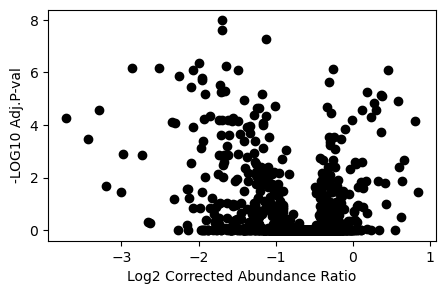

In [25]:
x = datatcl['Log2 Corrected Abundance Ratio']
y = datatcl['LOG10 Adj.P-val']

fig, ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
ax.scatter(x, y, c='k')
ax.set_xlabel('Log2 Corrected Abundance Ratio')
ax.set_ylabel('-LOG10 Adj.P-val')

##### 2. Réaliser des versions évoluées du graphique précédent
L'objectif est de mettre l'accent sur la région **-Log10 adj Pvalue > 4** et **Log2 corrected abundance ratio > 0**.
<br/>Pour cela vous revisiterez le scatter plot précedent au travers des versions suivantes:
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ première version : un rectangle de la couleur de votre choix matérialisera la région</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ deuxième version  : une couleur de votre choix représentera les points de la région</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ troisème version (optionnel): Les identifiants uniprot remplaceront les points des protéines de la région</span>

In [26]:
import matplotlib.patches as patches

In [27]:
x_list = datatcl['Log2 Corrected Abundance Ratio'].to_list()
y_list = datatcl['LOG10 Adj.P-val'].to_list()

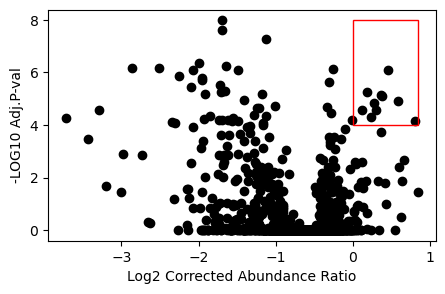

In [28]:
# datatcl['LOG10 Adj.P-val'] > 4
# datatcl['Log2 Corrected Abundance Ratio'] > 0

fig, ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
ax.scatter(x, y, c='k')
ax.set_xlabel('Log2 Corrected Abundance Ratio')
ax.set_ylabel('-LOG10 Adj.P-val')

my_rect = patches.Rectangle(
    (0, 4),
    max(x), (max(y) - 4),
    linewidth=1,
    edgecolor='r',
    facecolor='none'
)
ax.add_patch(my_rect)

plt.show()

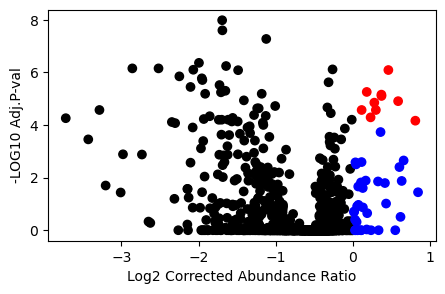

In [29]:
# datatcl['LOG10 Adj.P-val'] > 4
# datatcl['Log2 Corrected Abundance Ratio'] > 0

col = np.where(x_df > 0,np.where(y_df > 4,'r','b'),'k')

fig1, f1_ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
f1_ax.scatter(x, y, c=col)
f1_ax.set_xlabel('Log2 Corrected Abundance Ratio')
f1_ax.set_ylabel('-LOG10 Adj.P-val')

plt.show()

In [57]:
#print(datatcl['Gene Symbol'])

for i, txt in enumerate(datatcl['Accession']):
    #print(max(datatcl['LOG10 Adj.P-val'].to_list()))
    if datatcl['LOG10 Adj.P-val'].to_list()[i] > 4 and datatcl['Log2 Corrected Abundance Ratio'].to_list()[i] > 0:
        print(i, txt)

1719 P0ACF8
1724 P62399
1726 P0A905
1728 P76506
1729 P13036
1733 P06971
1734 P0A910
1737 P06996
1739 P76344
1744 P02931


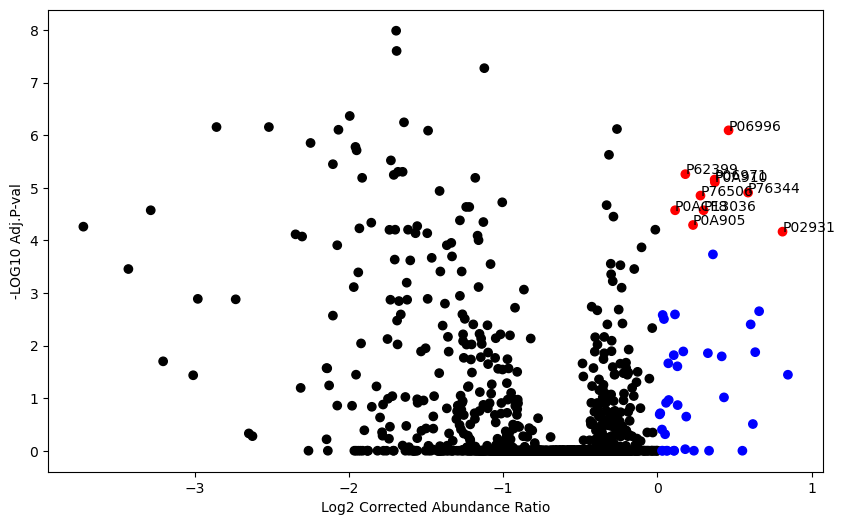

In [66]:
# datatcl['LOG10 Adj.P-val'] > 4
# datatcl['Log2 Corrected Abundance Ratio'] > 0

col = np.where(x > 0,np.where(y > 4,'r','b'),'k')

fig, ax = plt.subplots(figsize=(10,6), ncols=1, nrows=1)
ax.scatter(x, y, c=col)
ax.set_xlabel('Log2 Corrected Abundance Ratio')
ax.set_ylabel('-LOG10 Adj.P-val')

for i, txt in enumerate(datatcl['Accession']):
    if x_list[i] > 0 and y_list[i] > 4:
        #print(txt)
        ax.annotate(txt, (x_list[i], y_list[i]))

plt.show()

#### Analyse ORA

##### Principes
Vous disposez d'un objet analyser permettant de réaliser une analyse de la sur-représentation (**ORA**) en termes GO parmi une liste de protéine d'intérêt.
La fréquence des termes GO dans le protéome totale est utilisée comme référence.

L'objet analyser s'instancie ainsi
```python
from stat_utils import GO_ORA_analyser
o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")
```

Il fournit une méthode pour chaque catégorie de termes GO
<i>{ biological_process, molecular_function, cellular_component }</i>

Une éventuelle surreprésentation des termes GO de la catégorie <i>biological_process</i> est par exemple calculée parmi les protéines P29744 et P05706 de la façon suivante:

```python
goTerm_scores = o.biological_process(["P29744", "P05706"])
```
<span style="color:green;font-weight:bold">$\uparrow$ Reproduire cet exemple dans la cellule ci-dessous.$\downarrow$ </span>
</br><span style="color:firebrick;font-weight:bold"> $\rhd$ Inspecter l'objet retourné par la méthode o.biological_process, que voyez-vous ?</span>

o = GO...
contiendra l'ontologie GO

en faisant o.biological_process([prots surexrimées])

il fait un test de Fisher

pour chaque terme GO, prots qui sont dans le terme et les autres, X prots abondantes et prots non abondantes (table de contingence)

-> itérable : {terme GO, nom GO, p-valeur, protéines membres}

ordonner par p-valeur, tri par nb de membres, choix : p-val remarquable avec un gd nombre de membres pour les colorier ou non
scatterplot : colorier les membres du terme GO 'xxx'

df.loc['FC' >= 0.16]['Accession']

In [ ]:
from stat_utils import GO_ORA_analyser
o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")

Loading ontology


###### 2/ Analyser la représentation des termes GO parmi les protéines surabondantes de l'experience
<span style="color:firebrick;font-weight:bold"> $\rhd$ Vous devrez extraire les identifiants uniprot des protéines aux `Log2 Corrected Abundance Ratio` supérieurs au seuil alpha de 5%.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous conduirez sur cette liste de protéines une analyse de sur-représentation en termes GO à l'aide d'un objet *GO_ORA_analyser*.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous pouvez faire varier le seuil d'abondance autour de la valeur alpha.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous traiterez les 3 catégories *biological_process / molecular_function /cellular_component*.</span>



Familiarisez-vous avec la structures des dictionnaires de résultas, vous pouvez [les sauvegarder au format json](https://docs.python.org/3/library/json.html).


## Une première application: représentation riche du résultat de l'analyse


### Mise en forme "riche" des résultats grâce au notebook

Jupyter permet d'étendre le concept de la méthode **__str__()** afin de produire du contenu HTML.
 Ainsi, tout objet impémentant une méthode **_repr_html_()** sera affiché, via son rendu HTML, dans la cellule d'un notebook.

```python
class Point():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>Abscisse</td><td>Ordonnée</td><td>Cote</td></tr></thead>"
        htmlString += f"<tbody><tr><td>{self.x}</td><td>{self.y}</td><td>{self.z}</td></tr></tbody></table>"
        return htmlString
Point(2,3,4)
```
Affichera

![caption](../figs/reprhtml.png)


### Intégration des résultats à la visualisation du notebook 

En vous inspirant de la fonction ci-dessus, implémenter une classe Rich_GO_ORA dont la méthode [`_repr_html_`](https://ipython.readthedocs.io/en/stable/config/integrating.html) permettra un affichage plus lisible d'une des analyses `biological_process / molecular_function /cellular_component`

Un exemple possible est,
![caption](../figs/_repr_html_.png)

(Bonus): clicker sur le nom du terme GO envoie vers sa description.
Pour cela, afficher le nom du pathway dans une balise hyperlien pour permettre d'acceder à la page de description du terme GO. 

Les termes GO sont accessibles aux URL de la forme
`http://amigo.geneontology.org/amigo/term/GO:GO_NUMBER`.




## Une deuxième application: volcano plot améliorés
###### PANDAS
En choisissant comme seuil la valeur `alpha` du TP précédent, veuillez extraires les identifiants uniprot des protéines sur-abondantes (rappel les valeurs d'abondance sont celles de la colonne `Log2 Corrected Abundance Ratio`).

Vous devrez avoir dans des listes distinctes:
* identifiants uniprot
* `Log2 Corrected Abundance Ratio`
* `LOG10 Adj.P-val'`

###### Représentation graphiques
* Pour la catégorie de termes GO (biological_process / molecular_function /cellular_component) de votre choix
    * Générer une grille de 4 graphiques 
    * Dans chaque graphique colorez dans une couleur différentes les protéines porteuses de 4 termes de GO que vous estimez les plus pertinents 
    * Donnez le nom de la catégorie générale à la grille
    * Donnez le nom du terme GO représenté dans chaque graphique avec une couleur de titre cohérente.
    